# 7. The Crsp Sample and Market Factor

In [1]:
"""Imports"""
import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) #set default figure size
from pandas.tseries.offsets import *

## 7.1 The U.S. Stock Market

**Composition**: *NYSE* (1925/01 - present), *AMEX* (1962/07 - present), *NASDAQ* (1972/12 - present) and others.

**Frequncy**: *Monthly* and *Daily*.

In [2]:
# Connect to WRDS
conn = wrds.Connection(wrds_username='zhenqihu2')
# CRSP Monthly Data (crsp.msf & crsp.msenames)
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd, b.siccd, b.shrcls,
                      a.ret, a.retx, a.shrout, a.prc, a.altprc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '12/31/1925' and '12/31/2012'
                      """, date_cols=['date']) 
# Delisting Return (crsp.msedelist)
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt, dlstcd 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])
# Fama-French Monthly Factor Data (ff.factors_monthly)
ff_m = conn.get_table(library='ff', table='factors_monthly')
# Market Indices (crsp.msi)
msi = conn.get_table(library='crsp', table='msi')
# End the WRDS Connection
conn.close()
# change variable format to int
crsp_m[['permco','permno']] = crsp_m[['permco','permno']].astype(int)
dlret.permno = dlret.permno.astype(int)

# Line up date to be end of month
crsp_m['jdate'] = crsp_m['date'] + MonthEnd(0)
dlret['jdate'] = dlret['dlstdt'] + MonthEnd(0)
ff_m['jdate'] = ff_m['date'] + MonthEnd(0)
msi['jdate'] = msi['date'] + MonthEnd(0)
# Merge different datasets
crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp = pd.merge(crsp, ff_m[['jdate', 'mktrf', 'rf']], how='left', on=['jdate'])
crsp = pd.merge(crsp, msi[['jdate', 'vwretd']], how='left', on=['jdate'])

Loading library list...
Done


In [3]:
# U.S.-based common stocks: sharecode ('SHRCD') = 10 or 11
crsp.query('shrcd == 10 or shrcd == 11', inplace=True)
crsp[['permco','permno','shrcd','exchcd']]=crsp[['permco','permno','shrcd','exchcd']].astype(int) # change variable format to int
# Market Values
crsp['me'] = crsp['shrout'] * crsp['altprc'].abs() / 1000 # measured in millions of dollars

In [4]:
crsp

,permno,permco,date,shrcd,exchcd,siccd,shrcls,ret,retx,shrout,prc,altprc,jdate,dlret,dlstdt,dlstcd,mktrf,rf,vwretd,me
1,10000,7952,1986-01-31,10,3,3990.0,A,NaN,NaN,3680.0,-4.375000,-4.375000,1986-01-31,NaN,NaT,NaN,0.0065,0.0056,0.009830,16.100000
2,10000,7952,1986-02-28,10,3,3990.0,A,-0.257143,-0.257143,3680.0,-3.250000,-3.250000,1986-02-28,NaN,NaT,NaN,0.0713,0.0053,0.072501,11.960000
3,10000,7952,1986-03-31,10,3,3990.0,A,0.365385,0.365385,3680.0,-4.437500,-4.437500,1986-03-31,NaN,NaT,NaN,0.0488,0.0060,0.053887,16.330000
4,10000,7952,1986-04-30,10,3,3990.0,A,-0.098592,-0.098592,3793.0,-4.000000,-4.000000,1986-04-30,NaN,NaT,NaN,-0.0131,0.0052,-0.007903,15.172000
5,10000,7952,1986-05-30,10,3,3990.0,A,-0.222656,-0.222656,3793.0,-3.109375,-3.109375,1986-05-31,NaN,NaT,NaN,0.0462,0.0049,0.050847,11.793859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990995,93436,53453,2012-08-31,11,3,9999.0,None,0.040117,0.040117,105432.0,28.520000,28.520000,2012-08-31,NaN,NaT,NaN,0.0255,0.0001,0.026337,3006.920688
3990996,93436,53453,2012-09-28,11,3,9999.0,None,0.026648,0.026648,105772.0,29.280001,29.280001,2012-09-30,NaN,NaT,NaN,0.0273,0.0001,0.026532,3097.004233
3990997,93436,53453,2012-10-31,11,3,9999.0,None,-0.039228,-0.039228,113779.0,28.131399,28.131399,2012-10-31,NaN,NaT,NaN,-0.0176,0.0001,-0.014064,3200.762464
3990998,93436,53453,2012-11-30,11,3,9999.0,None,0.202215,0.202215,113779.0,33.820000,33.820000,2012-11-30,NaN,NaT,NaN,0.0078,0.0001,0.006219,3848.005745


### 7.1.2 Composition of the CRSP Sample

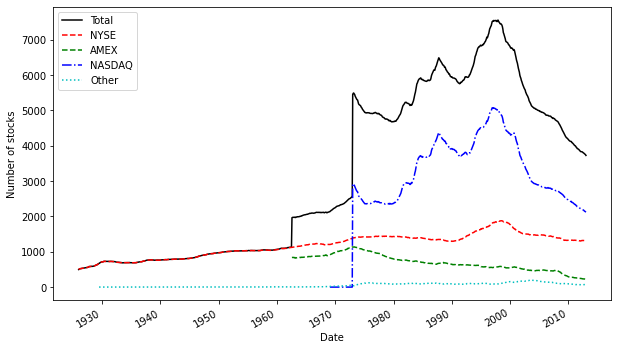

In [5]:
"""Number of Stocks in CRSP Sample by Exchange"""

crsp['nyse'] = crsp['exchcd'].isin([1, 31])
crsp['amex'] = crsp['exchcd'].isin([2, 32])
crsp['nasdaq'] = crsp['exchcd'].isin([3, 33])

fig, ax = plt.subplots()
crsp.groupby('date')['permno'].count().plot(color='black', linestyle='-', label='Total')
crsp.groupby('date')['nyse'].sum().plot(color='r', linestyle='--', label='NYSE')
crsp.groupby('date')['amex'].sum().loc['1962-7-31':].plot(color='g', linestyle='--', label='AMEX') # 1962-07
crsp.groupby('date')['nasdaq'].sum().loc['1969-1-31':].plot(color='blue', linestyle='-.', label='NASDAQ') # 1969-01 & 1972-12
crsp.query('nyse == 0 & amex == 0 & nasdaq == 0 ').groupby('date')['permno'].count().plot(color='c', linestyle=':', label='Other')
ax.legend(loc=2)
ax.set_ylabel('Number of stocks')
ax.set_xlabel('Date')
plt.show()

In [6]:
crsp.groupby('date')['permno'].count()

date
1925-12-31     497
1926-01-30     508
1926-02-27     517
1926-03-31     520
1926-04-30     525
              ... 
2012-08-31    3784
2012-09-28    3767
2012-10-31    3760
2012-11-30    3749
2012-12-31    3726
Name: permno, Length: 1045, dtype: int64

In [7]:
crsp.groupby('date')[['nyse', 'amex', 'nasdaq']].sum()

,nyse,amex,nasdaq
date,,,
1925-12-31,497,0,0
1926-01-30,508,0,0
1926-02-27,517,0,0
1926-03-31,520,0,0
1926-04-30,525,0,0
...,...,...,...
2012-08-31,1317,231,2166
2012-09-28,1316,230,2150
2012-10-31,1319,228,2143


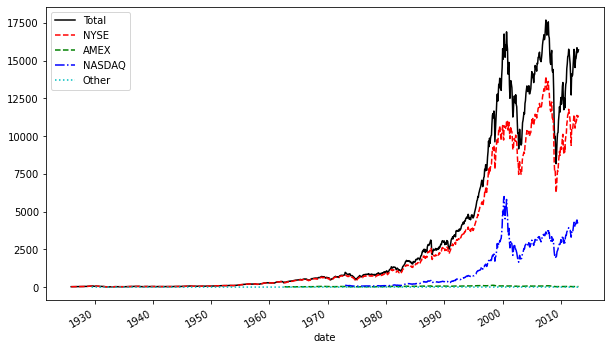

In [8]:
"""Value of Stocks in CRSP Sample by Exchange"""

fig, ax = plt.subplots()
(crsp.groupby('date')['me'].sum() / 1000).plot(color='black', linestyle='-', label='Total')
(crsp.query('nyse == 1').groupby('date')['me'].sum() / 1000).plot(color='r', linestyle='--', label='NYSE')
(crsp.query('amex == 1').groupby('date')['me'].sum() / 1000).plot(color='g', linestyle='--', label='AMEX')
(crsp.query('nasdaq == 1').groupby('date')['me'].sum() / 1000).plot(color='blue', linestyle='-.', label='NASDAQ')
(crsp.query('nyse == 0 & amex == 0 & nasdaq == 0 ').groupby('date')['me'].sum() / 1000).plot(color='c', linestyle=':', label='Other')
ax.legend()
plt.show()

In [9]:
crsp.groupby('date')['me'].sum() / 1000

date
1925-12-31       26.913057
1926-01-30       27.235761
1926-02-27       26.277727
1926-03-31       24.573609
1926-04-30       25.478191
                  ...     
2012-08-31    15452.410789
2012-09-28    15855.992369
2012-10-31    15539.282558
2012-11-30    15597.104409
2012-12-31    15715.160012
Name: me, Length: 1045, dtype: float64

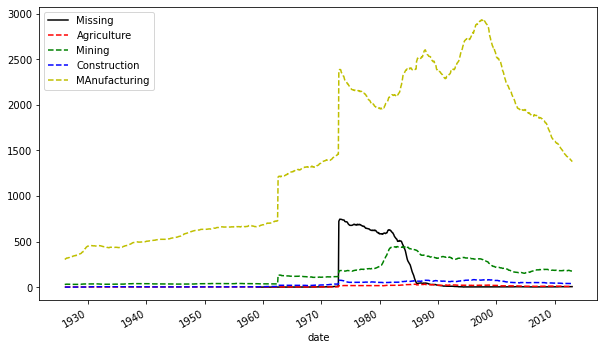

In [10]:
"""Number of Stocks in CRSP Sample by Industry"""

fig, ax = plt.subplots()
crsp.query("siccd == 0").groupby('date')['permno'].count().plot(color='black', linestyle='-', label='Missing')
crsp.query("siccd >= 1 and siccd <= 999").groupby('date')['permno'].count().plot(color='r', linestyle='--', label='Agriculture')
crsp.query("siccd >= 1000 and siccd <= 1499").groupby('date')['permno'].count().plot(color='g', linestyle='--', label='Mining')
crsp.query("siccd >= 1500 and siccd <= 1799").groupby('date')['permno'].count().plot(color='b', linestyle='--', label='Construction')
crsp.query("siccd >= 2000 and siccd <= 3999").groupby('date')['permno'].count().plot(color='y', linestyle='--', label='MAnufacturing')
ax.legend()
plt.show()

## 7.2. Stock Retuns and Excess Returns

### 7.2.0 Monthly Stocks Returns and Adjustments

**"Ret"** field: the return realized by holding the stock from its last trade in the previous month to its last trade in the current month.

**"DLSTDT"**: the date of the stock delisting

**"DLSTCD"**: the code indicate the reason for delisting

**"DLRET"**: the delisting return

#### Adjusted return calculation suggested by Shumway(1997):
- not delisting: ret
- delisting:
    - dlret is available: dlret
    - dlret is unavailable:
      - dlstcd belongs to 500, 520, [551, 573], 574, 580 or 584: -30%
      - dlstcd not belongs to above: -100%

In [11]:
dlstcd_list = [500, 520] + list(range(551,575)) + [580, 584]
dlstcd_in_list = crsp['dlstcd'].map(lambda x: x in dlstcd_list)
dlret_isna = crsp['dlret'].isna()
dlstcd_isna = crsp['dlstcd'].isna()
ret_isna = crsp['ret'].isna()

In [12]:
crsp.loc[(dlstcd_in_list) & (dlret_isna), 'dlret'] = -0.3
crsp.loc[(dlstcd_in_list) & (dlret_isna)][['dlstcd', 'dlret']]

,dlstcd,dlret
47217,551.0,-0.3
155743,580.0,-0.3
161647,500.0,-0.3
196470,580.0,-0.3
202974,561.0,-0.3
...,...,...
3570191,552.0,-0.3
3585048,570.0,-0.3
3724451,580.0,-0.3
3791660,580.0,-0.3


In [13]:
crsp.loc[(- dlstcd_in_list) & (- dlstcd_isna) & (dlret_isna), 'dlret'] = -1
crsp.loc[(- dlstcd_in_list) & (- dlstcd_isna) & (dlret_isna)][['dlstcd', 'dlret']]

,dlstcd,dlret
321218,160.0,-1.0
422051,231.0,-1.0
501181,575.0,-1.0
506236,200.0,-1.0
552031,550.0,-1.0
632372,550.0,-1.0
669831,550.0,-1.0
677141,582.0,-1.0
819924,516.0,-1.0
1055094,234.0,-1.0


In [14]:
crsp['retadj'] = crsp['ret']
crsp.loc[- crsp['dlret'].isna(), 'retadj'] = crsp.loc[- crsp['dlret'].isna(), 'dlret'] # can't use dlret_isna now

In [15]:
crsp['ex_ret'] = crsp['ret'] - crsp['rf']
crsp['ex_retadj'] = crsp['retadj'] - crsp['rf']
crsp['ex_vwretd'] = crsp['vwretd'] - crsp['rf']

In [16]:
crsp_ret = crsp[['permno', 'jdate', 'ret', 'retadj', 'mktrf', 'rf', 'vwretd', 'ex_ret', 'ex_retadj', 'ex_vwretd']]
crsp_ret

,permno,jdate,ret,retadj,mktrf,rf,vwretd,ex_ret,ex_retadj,ex_vwretd
1,10000,1986-01-31,NaN,NaN,0.0065,0.0056,0.009830,NaN,NaN,0.004230
2,10000,1986-02-28,-0.257143,-0.257143,0.0713,0.0053,0.072501,-0.262443,-0.262443,0.067201
3,10000,1986-03-31,0.365385,0.365385,0.0488,0.0060,0.053887,0.359385,0.359385,0.047887
4,10000,1986-04-30,-0.098592,-0.098592,-0.0131,0.0052,-0.007903,-0.103792,-0.103792,-0.013103
5,10000,1986-05-31,-0.222656,-0.222656,0.0462,0.0049,0.050847,-0.227556,-0.227556,0.045947
...,...,...,...,...,...,...,...,...,...,...
3990995,93436,2012-08-31,0.040117,0.040117,0.0255,0.0001,0.026337,0.040017,0.040017,0.026237
3990996,93436,2012-09-30,0.026648,0.026648,0.0273,0.0001,0.026532,0.026548,0.026548,0.026432
3990997,93436,2012-10-31,-0.039228,-0.039228,-0.0176,0.0001,-0.014064,-0.039328,-0.039328,-0.014164
3990998,93436,2012-11-30,0.202215,0.202215,0.0078,0.0001,0.006219,0.202115,0.202115,0.006119


In [17]:
crsp_ret = crsp_ret.loc[(crsp_ret['jdate'] >= '1926-7-31') & (crsp_ret['jdate'] <= '2012-12-31')]

In [18]:
crsp_ret.groupby('jdate')[['ex_retadj', 'retadj', 'ex_ret', 'ret']].describe().mean()

ex_retadj  count    3094.141618
           mean        0.009902
           std         0.132778
           min        -0.559796
           25%        -0.057519
           50%        -0.000783
           75%         0.061811
           max         1.866468
retadj     count    3094.141618
           mean        0.012807
           std         0.132778
           min        -0.556891
           25%        -0.054614
           50%         0.002122
           75%         0.064716
           max         1.869372
ex_ret     count    3094.137765
           mean        0.009932
           std         0.132727
           min        -0.544177
           25%        -0.057524
           50%        -0.000773
           75%         0.061835
           max         1.867834
ret        count    3094.137765
           mean        0.012837
           std         0.132727
           min        -0.541273
           25%        -0.054619
           50%         0.002131
           75%         0.064740
        

### 7.2.1 CRSP Sample (1963-2012)

In [19]:
crsp_ret_short = crsp_ret.loc[(crsp_ret['jdate'] >= '1963-7-31') & (crsp_ret['jdate'] <= '2012-12-31')]

In [20]:
crsp_ret_short.groupby('jdate')[['ex_retadj', 'retadj', 'ex_ret', 'ret']].describe().mean()

ex_retadj  count    4751.843434
           mean        0.007919
           std         0.155083
           min        -0.700365
           25%        -0.066855
           50%        -0.003607
           75%         0.065001
           max         2.665029
retadj     count    4751.843434
           mean        0.012156
           std         0.155083
           min        -0.696128
           25%        -0.062618
           50%         0.000630
           75%         0.069238
           max         2.669265
ex_ret     count    4751.836700
           mean        0.007951
           std         0.155034
           min        -0.678727
           25%        -0.066866
           50%        -0.003594
           75%         0.065031
           max         2.666592
ret        count    4751.836700
           mean        0.012188
           std         0.155034
           min        -0.674490
           25%        -0.062629
           50%         0.000643
           75%         0.069267
        

## 7.3 Market Factor

In [21]:
crsp_mf = crsp_ret.groupby('jdate')[['mktrf', 'ex_vwretd']].mean()
crsp_mf

,mktrf,ex_vwretd
jdate,,
1926-07-31,0.0296,0.029211
1926-08-31,0.0264,0.026147
1926-09-30,0.0036,0.003487
1926-10-31,-0.0324,-0.032196
1926-11-30,0.0253,0.025454
...,...,...
2012-08-31,0.0255,0.026237
2012-09-30,0.0273,0.026432
2012-10-31,-0.0176,-0.014164


In [22]:
crsp_mf.describe()

,mktrf,ex_vwretd
count,1038.000000,1038.000000
mean,0.006284,0.006258
std,0.054502,0.054602
min,-0.291300,-0.292031
25%,-0.020600,-0.021368
50%,0.009900,0.009639
75%,0.036500,0.036722
max,0.388500,0.393143


In [23]:
np.corrcoef(crsp_mf['mktrf'], crsp_mf['ex_vwretd'])

array([[1.        , 0.99955958],
       [0.99955958, 1.        ]])

In [24]:
ff_m['log_ex_mkt'] = ff_m['mktrf'].apply(lambda x: np.log(x + 1))
ff_data = ff_m.loc[ff_m['jdate'] <= '2012-12-31']
ff_data[['mktrf', 'log_ex_mkt']].mean()

mktrf         0.006284
log_ex_mkt    0.004788
dtype: float64

In [25]:
ff_data[['mktrf', 'log_ex_mkt']].std()

mktrf         0.054502
log_ex_mkt    0.054568
dtype: float64

In [26]:
ff_data['mktrf'].apply(lambda x: x+1).cumprod()

0         1.029600
1         1.056781
2         1.060586
3         1.026223
4         1.052186
           ...    
1033    139.919023
1034    143.738812
1035    141.209009
1036    142.310440
1037    143.989703
Name: mktrf, Length: 1038, dtype: float64

In [27]:
ff_data['log_ex_mkt'].cumsum()

0       0.029170
1       0.055228
2       0.058821
3       0.025885
4       0.050870
          ...   
1033    4.941064
1034    4.967998
1035    4.950241
1036    4.958011
1037    4.969742
Name: log_ex_mkt, Length: 1038, dtype: float64

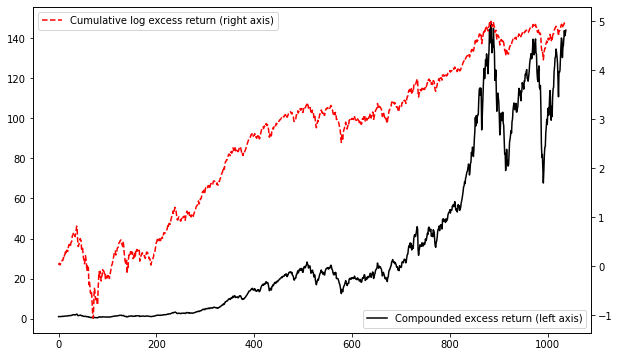

In [28]:
fig, ax1 = plt.subplots()
ff_data['mktrf'].apply(lambda x: x+1).cumprod().plot(color='black', linestyle='-', label='Compounded excess return (left axis)')
ax1.legend(loc=4)

ax2 = ax1.twinx()
ff_data['log_ex_mkt'].cumsum().plot(color='r', linestyle='--', label='Cumulative log excess return (right axis)')
ax2.legend(loc=2)
plt.show()